# 0 Imports

In [18]:
import pickle
import datetime

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from prophet    import Prophet

from IPython.display        import Image
from IPython.core.display   import HTML

from sklearn.preprocessing  import OrdinalEncoder
from category_encoders import CountEncoder

In [2]:
# Supressão da notação científica.
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', '{:.6f}'.format)

## 0.1 Funções Suporte

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [18,8]
    plt.rcParams['font.size'] = 14
    
    display( HTML('<style>.container { width: 100% !important;} </style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False)
    
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [4]:
def abrir_arquivo()-> pd.DataFrame:
    with open(f"{__CAMINHO_INTERIM}{__NOME_ARQUIVO_IMPORTAR}","rb") as arquivo:
        df = pickle.load(arquivo)
    return df

In [5]:
def exportar_df(df: pd.DataFrame):
    df.to_pickle(f'{__CAMINHO_INTERIM}{__NOME_ARQUIVO_EXPORTAR}')

In [31]:
def estatistica_descritiva(df1):
    # Medidas de tendência central - Mean, Median
    media = pd.DataFrame(df1.apply(np.mean)).T
    mediana = pd.DataFrame(df1.apply(np.median)).T
    
    # Medidas de Dispersão - Std, min, max, range, skew, kurtosis
    desvio_padrao = pd.DataFrame(df1.apply(np.std)).T
    minimo = pd.DataFrame(df1.apply(np.min)).T
    maximo = pd.DataFrame(df1.apply(np.max)).T
    range = pd.DataFrame(df1.apply(lambda x : x.max() - x.min())).T
    assimetria = pd.DataFrame(df1.apply(lambda x : x.skew())).T
    curtosis = pd.DataFrame(df1.apply(lambda x : x.kurtosis())).T
    
    estatistica = pd.concat([minimo, maximo, range, media, mediana, desvio_padrao, assimetria, curtosis]).T.reset_index()
    estatistica.columns = ['variaveis','minimo', 'maximo', 'range', 'media', 'mediana', 'desvio_padrao', 'assimetria', 'curtosis']
    
    return estatistica

## 0.2 Load Data

In [6]:
__CAMINHO_RAW = '../data/raw/'
__CAMINHO_INTERIM = '../data/interim/'

__NOME_ARQUIVO_IMPORTAR = '4_0_eda_pos_fe.pkl'
__NOME_ARQUIVO_EXPORTAR = '5_0_preparacao_dados.pkl'

In [7]:
df = abrir_arquivo()

# 5.0 Preparação dos Dados

Observações do ponto 4.0 EDA pós FE:

### Negócio:

Existem 4 máquinas nessa estrutura, só serão necessário trabalhar com 2, por enquanto: UNICIN e CEAEC

### Variáveis Numéricas

Normalização:
1. Principalmente para a própria variável resposta de custo, tem muito outlier.

Reescala nos dados numéricos, testar e verificar reescala robusta a outliers:
1. Os custos derivativos (Agregados), até que estão bonitinhos, talvez não dê muito trabalho.
2. As datas construídas, talvez precisem de uma transformação, pois são cíclicas
3. As datas não cíclicas (ano_semana, ano_mes), vê como faz, qual transformação aplicar, ou só descartar, elas são 'str'.

Transformação:
1. A coluna date passar para sen e cos (cíclico).
2. Posso até fazer isso para todas as datas (anos, mês, dia, dia_da_semana, semana_ano)(cíclico).

### Variáveis Categóricas

Usa uma dessas aqui:

1. One Hot Encoding
2. Label Encoding
3. Ordinal Encoding
4. Target Encoding
5. Frequency Encoding
6. Embedding Encoding

## 5.1 Dados Pré Preparação

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6947 entries, 52365 to 59311
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   subscription_guid         6947 non-null   object        
 1   date                      6947 non-null   datetime64[ns]
 2   resource_guid             6947 non-null   object        
 3   service_name              6947 non-null   object        
 4   service_type              6947 non-null   object        
 5   service_region            6947 non-null   object        
 6   service_resource          6947 non-null   object        
 7   quantity                  6947 non-null   float64       
 8   cost                      6947 non-null   float64       
 9   maquina                   6947 non-null   object        
 10  ano                       6947 non-null   int32         
 11  mes                       6947 non-null   int32         
 12  dia                 

### Valores numéricos: 
1. quantity: log
2. cost: log
3. ano: 0 e 1
4. mes: sen-cos
5. dia: sen-cos
6. semana_ano: sen-cos
7. dia_da_semana: sen-cos
8. fim_de_semana: Não tem necessidade
9. custo_fixo_diario: log
10. custo_fixo_semanal: log
11. custo_fixo_mensal: log
12. custo_soma_movel_semanal: log
13. custo_soma_movel_mensal: log

### Valores Categóricos:

1. resource_guid: frequency encode
2. service_name: frequency encode
3. service_type: frequency encode
4. service_region: frequency encode
5. service_resource: frequency encode
6. ano_semana: ordinalencoder
7. ano_mes: ordinalencoder

### Drop:
1. subscription_guid
2. maquina

In [9]:
df.drop(columns=['subscription_guid', 'maquina'], inplace=True)

## 5.2 Normalização

In [10]:
log_coluns = [
                'quantity',
                'cost',
                'custo_fixo_diario',
                'custo_fixo_semanal',
                'custo_fixo_mensal',
                'custo_soma_movel_semanal',
                'custo_soma_movel_mensal'
                ]

df[log_coluns] = df[log_coluns].apply(lambda x: np.log1p(x))

# Modificar após aplicação do modelo. Aplica exponenciação
# df['cost'] = np.expm1( df['cost'] )
# df['predictions'] = np.expm1( yhat_modelo )

In [11]:
df['ano'] = df['ano'] - 2023

## 5.3 Reescala

In [15]:
df['mes_sen'] = df['mes'].apply( lambda x: np.sin( x * (2 * np.pi/12 ) ) )
df['mes_cos'] = df['mes'].apply( lambda x: np.cos( x * (2 * np.pi/12 ) ) )

df['dia_sen'] = df['dia'].apply( lambda x: np.sin( x * (2 * np.pi/30 ) ) )
df['dia_cos'] = df['dia'].apply( lambda x: np.cos( x * (2 * np.pi/30 ) ) )

df['semana_ano_sen'] = df['semana_ano'].apply( lambda x: np.sin( x * (2 * np.pi/52 ) ) )
df['semana_ano_cos'] = df['semana_ano'].apply( lambda x: np.cos( x * (2 * np.pi/52 ) ) )

df['dia_da_semana_sen'] = df['dia_da_semana'].apply( lambda x: np.sin( x * (2 * np.pi/7 ) ) )
df['dia_da_semana_cos'] = df['dia_da_semana'].apply( lambda x: np.cos( x * (2 * np.pi/7 ) ) )

## 5.4 Transformação

1. resource_guid: frequency encode
2. service_name: frequency encode
3. service_type: frequency encode
4. service_region: frequency encode
5. service_resource: frequency encode
6. ano_semana: ordinalencoder
7. ano_mes: ordinalencoder

In [19]:
frequency = [
            'resource_guid',
            'service_name',
            'service_type',
            'service_region',
            'service_resource'
            ]

# for f in frequency:
#     df[f] = df[f].map(df[f].value_counts(normalize=True))

_count_encoder = CountEncoder(normalize=True)

for f in frequency:
    df[f] = _count_encoder.fit_transform(df[f])


In [20]:
ordinal_ano_mes = df['ano_mes'].unique().tolist()

ano_mes_dict = {date: index for index, date in enumerate(ordinal_ano_mes, start=1)}

df['ano_mes'] = df['ano_mes'].map(ano_mes_dict)

In [21]:
ordinal_ano_semana= df['ano_semana'].unique().tolist()

ano_semana_dict = {date: index for index, date in enumerate(ordinal_ano_semana, start=1)}

df['ano_semana'] = df['ano_semana'].map(ano_semana_dict)

## 5.5 Dados Pós Preparação

<Axes: >

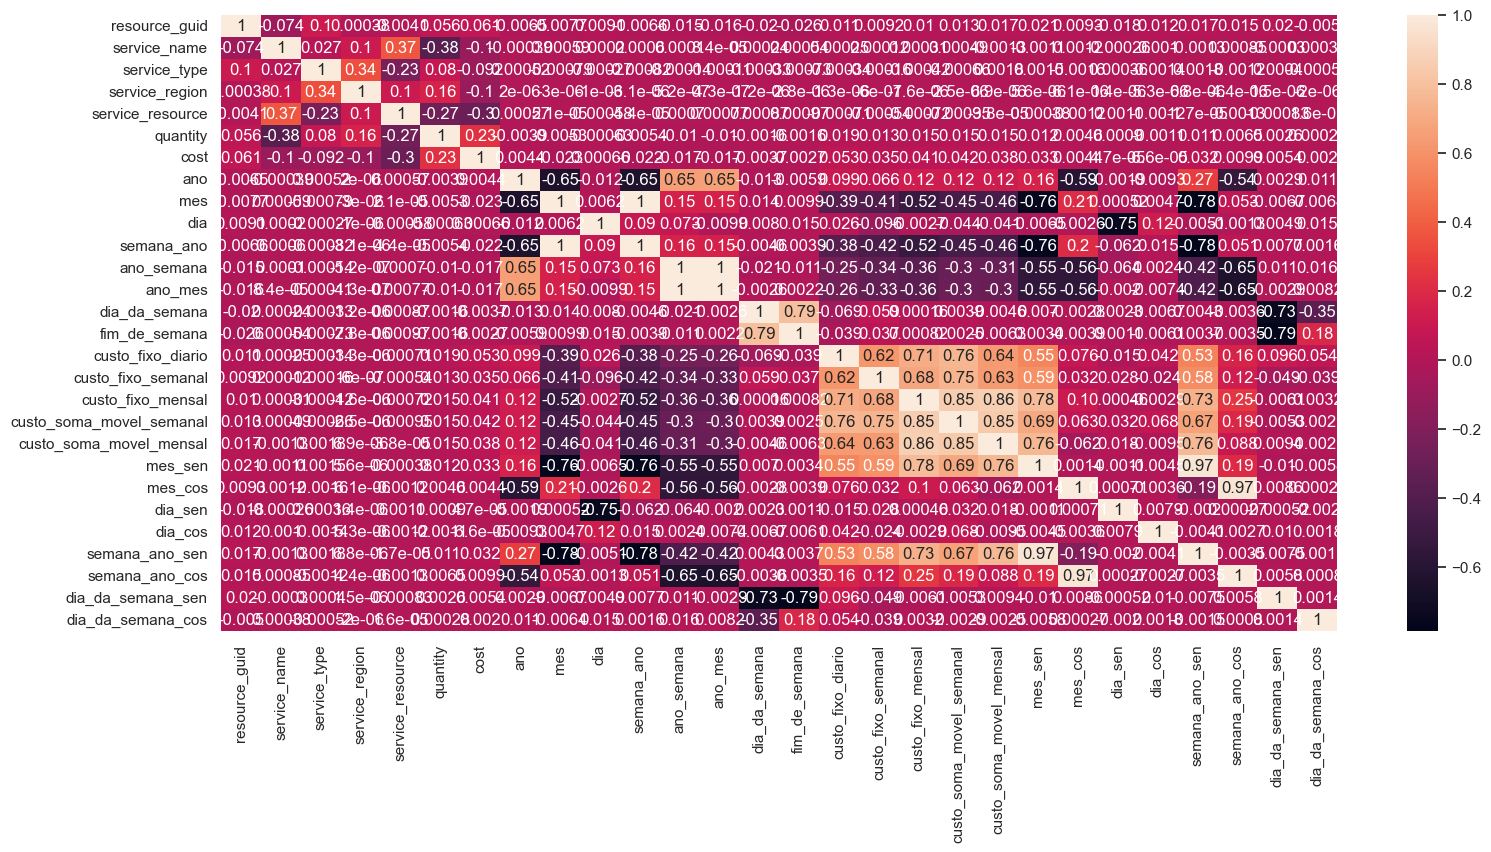

In [22]:
__corr = df.drop(columns=['date'])

correlation = __corr.corr( method= 'pearson')

sns.heatmap(correlation, annot=True)

In [27]:
df_num = df.select_dtypes(include=['int64','int32','float64'])

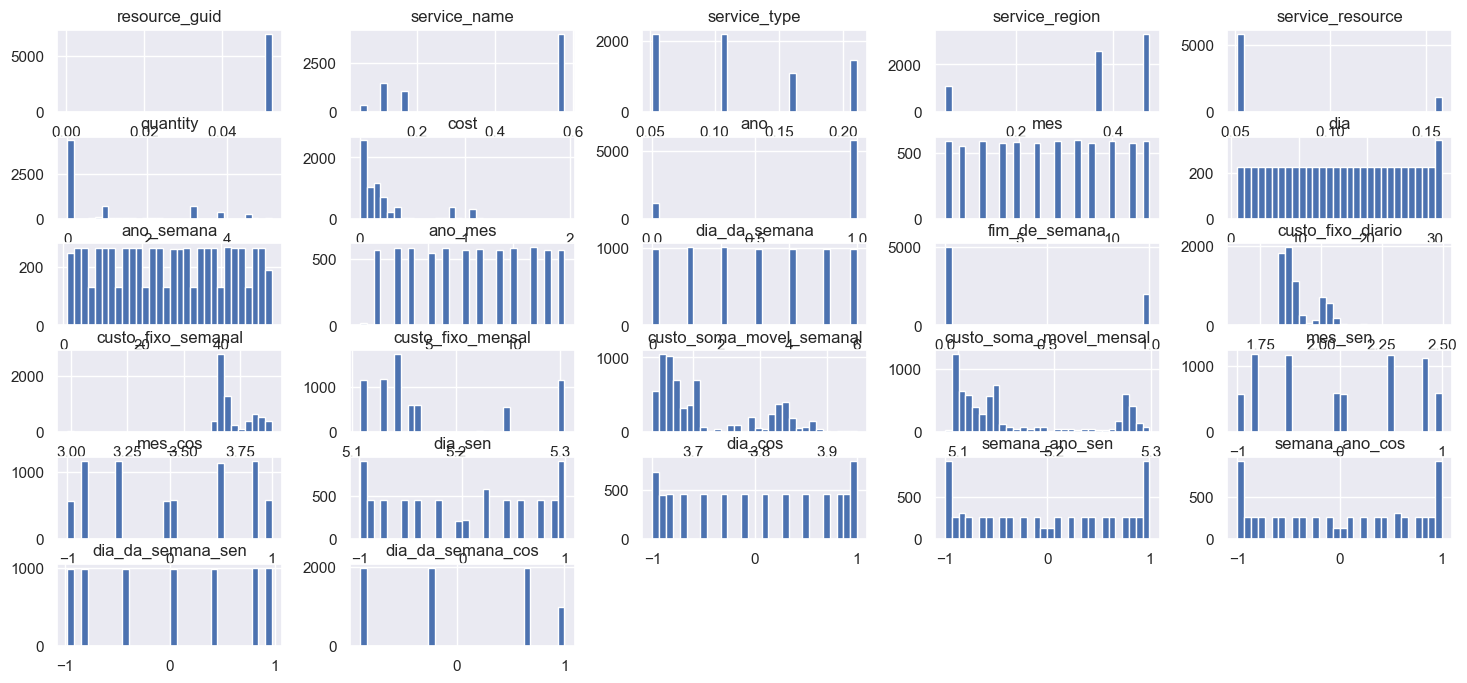

In [28]:
df_num.hist(bins=30);

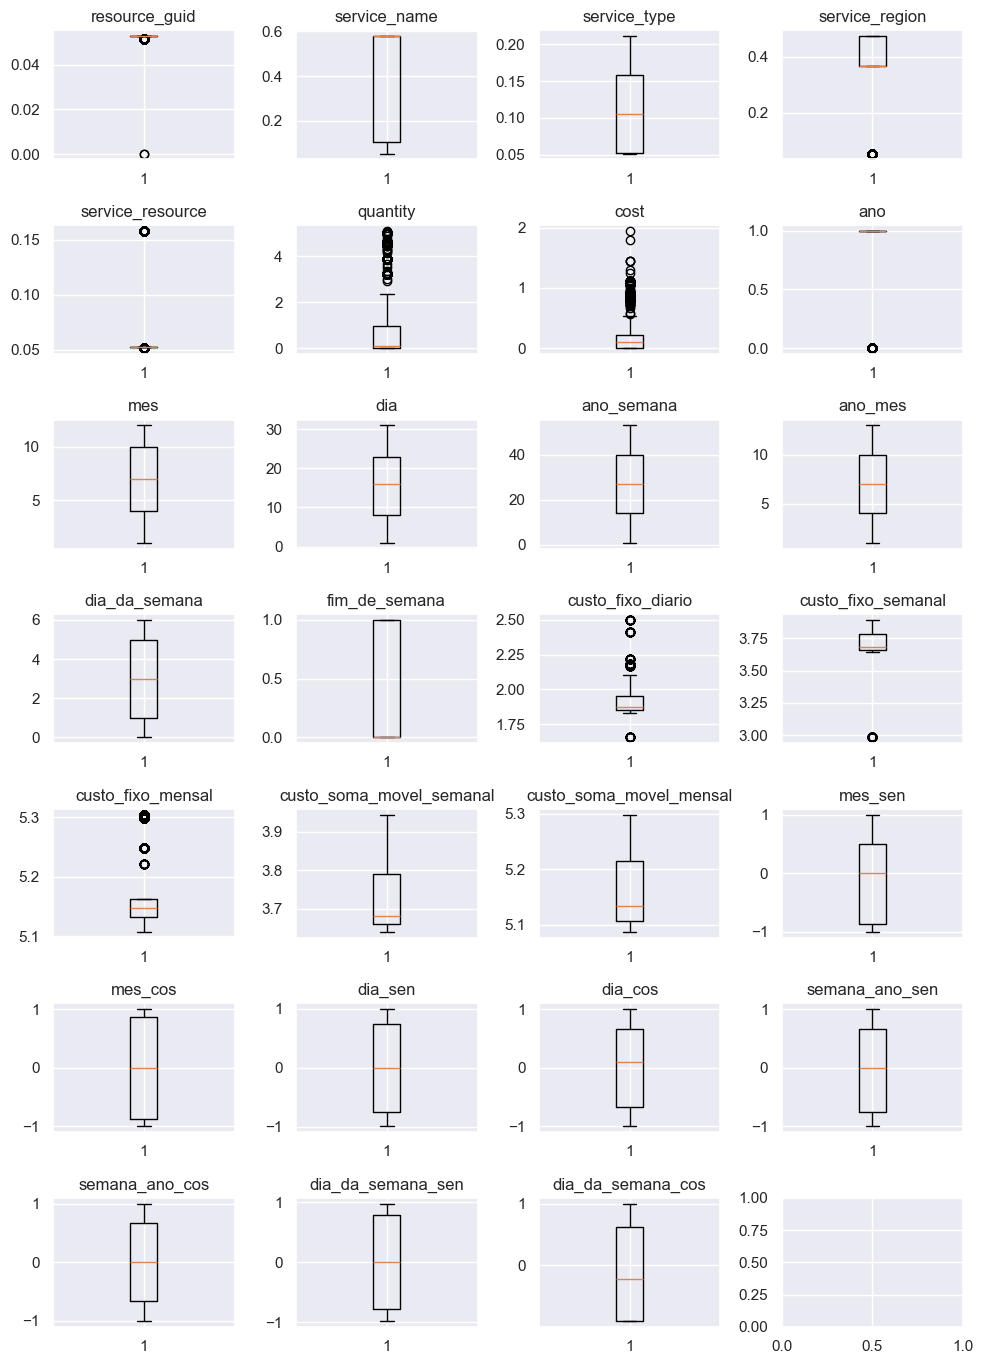

In [30]:
fig, axes = plt.subplots(7,4, figsize=(10, 15))

for ax, var in zip(axes.flatten(), df_num.columns):
    ax.boxplot(df_num[var])
    ax.set_title(f'{var}')
    #ax.set_ylabel(var)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [32]:
estatistica_descritiva(df_num)

,variaveis,minimo,maximo,range,media,mediana,desvio_padrao,assimetria,curtosis
0,resource_guid,0.000288,0.052685,0.052397,0.052603,0.052685,0.000933,-50.922691,2848.444394
1,service_name,0.052685,0.578523,0.525838,0.384651,0.578523,0.228261,-0.348281,-1.837957
2,service_type,0.051677,0.210738,0.159061,0.119249,0.105369,0.058873,0.373225,-1.219948
3,service_region,0.052685,0.474162,0.421477,0.368422,0.367785,0.145114,-1.444861,0.677198
4,service_resource,0.051389,0.158342,0.106953,0.069348,0.052685,0.038601,1.871966,1.505106
5,quantity,0.000000,5.119975,5.119975,0.979539,0.092368,1.499696,1.334386,0.194429
6,cost,0.000000,1.949702,1.949702,0.210111,0.100019,0.302535,1.937226,2.717218
7,ano,0.000000,1.000000,1.000000,0.830430,1.000000,0.375254,-1.761482,1.103136
8,mes,1.000000,12.000000,11.000000,6.516050,7.000000,3.452634,-0.007754,-1.212157
9,dia,1.000000,31.000000,30.000000,15.758889,16.000000,8.815375,0.003841,-1.198030


# 5.9 Export PKL

In [142]:
exportar_df(df=df)